In [2]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict

plt.rcParams['figure.figsize'] = [16, 68]
from plot_utils import *

# Timeline

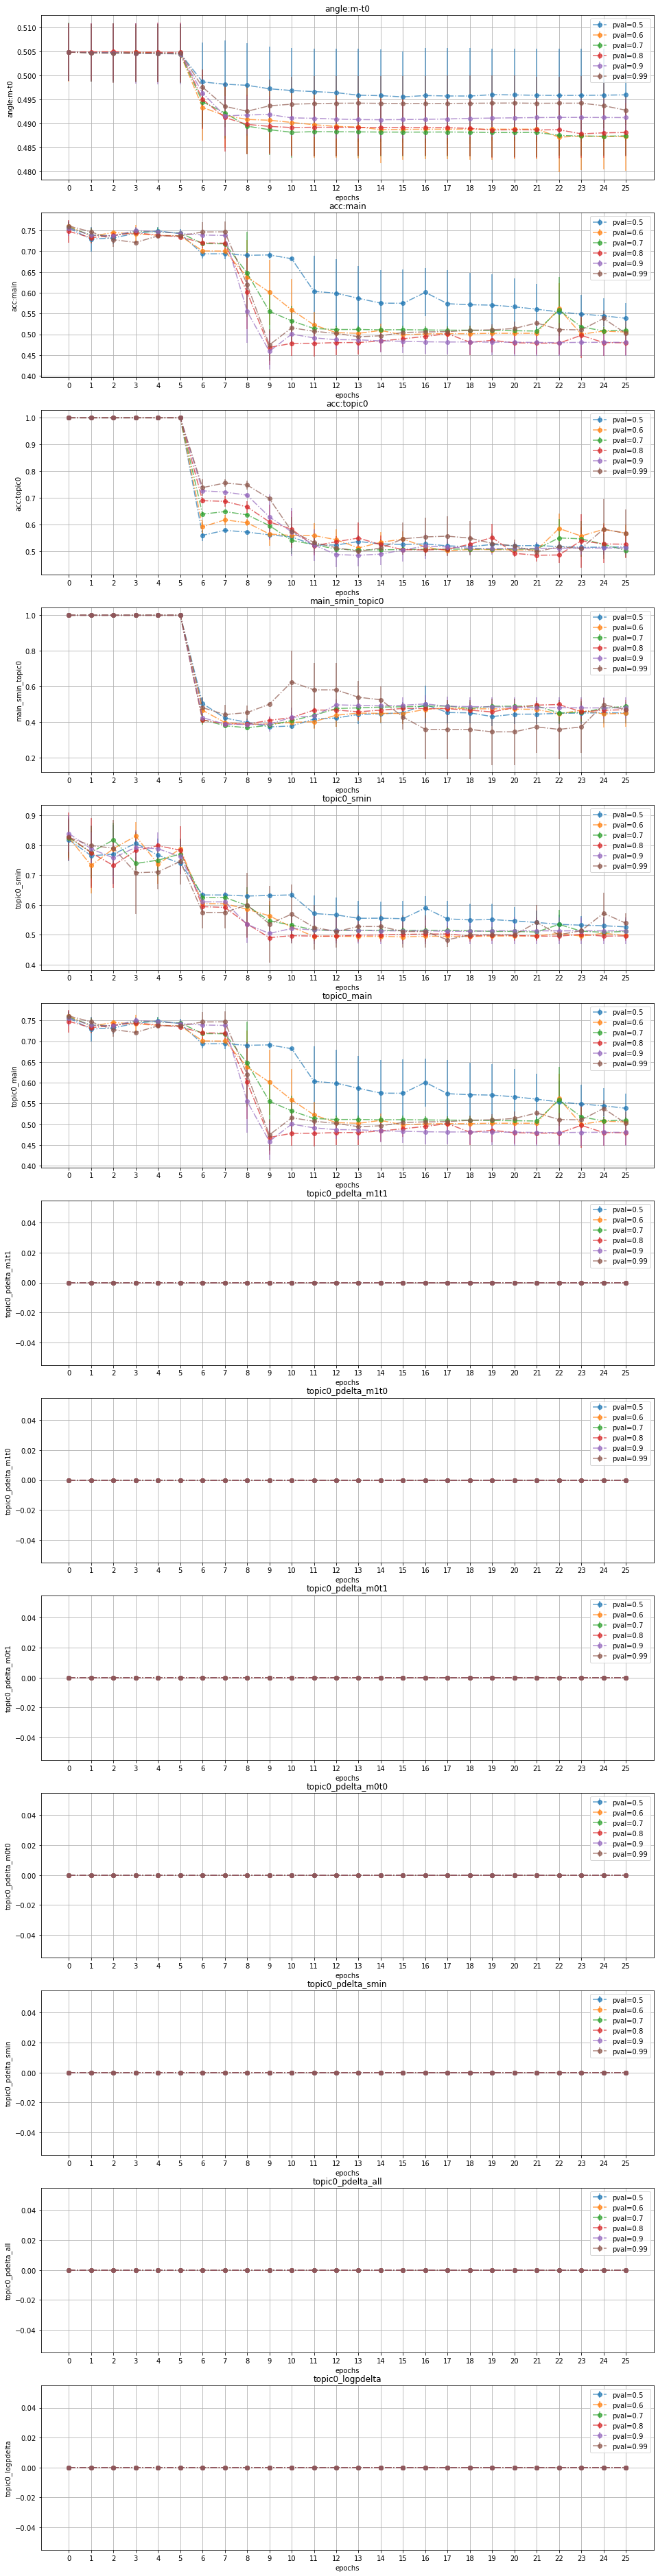

In [6]:
run_list=[1,2,3]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "main_smin_topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta_m1t1",
                    "topic0_pdelta_m1t0",
                    "topic0_pdelta_m0t1",
                    "topic0_pdelta_m0t0",
                    "topic0_pdelta_smin",
                    "topic0_pdelta_all",
                    "topic0_logpdelta",
]


ax=None

#Other hyperparam
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
mainmode="causal_same_sp" #causal_same_sp, causal_rebalance_sp
n=0.0
h=0
mainepoch=6
s=10000

model_type="bert-base-uncased"
remmode="null_space"
advepoch=20
topicepoch=1
neg1_flip_method="remove_negation"
dataset = "twitter_aae_sentiment_race"



all_result_dict = get_all_result_timeline(run_list=run_list,
                                      pval_list=pval_list,
                                      fname_pattern="dataset/{}/nlp_logs/pt.rel.mt({}).neg1_fmethod({}).remmode({}).mainmode({}).advepoch({}).topicepoch({}).lt({}).drate({}).l2({}).n({}).h({}).s({}).e({}).p({}).r({})/probe_metric_list.json".format(
                                                                              dataset,
                                                                              model_type,
                                                                              neg1_flip_method,
                                                                              remmode,
                                                                              mainmode,
                                                                              advepoch,
                                                                              topicepoch,
                                                                              lt,
                                                                              drate,
                                                                              l2,
                                                                              n,
                                                                              h,
                                                                              s,
                                                                              mainepoch,
                                                                              "{}",
                                                                              "{}",
                                      )
)
plot_one_timeline(pval_list,all_result_dict,plot_item_list)

# Variation with Samples

In [6]:
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic0_logpdelta"
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
mainmode="causal"
n=0.0
h=0
mainepoch=3
s=10000
remmode="null_space"
advepoch=7
topicepoch=1

for s in [10000,20000]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                      pval_list=pval_list,
                                      enum=mainepoch+advepoch,
                                      fname_pattern="nlp_logs/pt.rel.model_type({}).remmode({}).advepoch({}).topicepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                              model_type,
                                                                              remmode,
                                                                              advepoch,
                                                                              topicepoch,
                                                                              lt,
                                                                              l2,
                                                                              hretrain,
                                                                              mainmode,
                                                                              n,
                                                                              h,
                                                                              s,
                                                                              mainepoch,
                                                                              "{}",
                                                                              "{}",
                                      )
    )
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", sample={}".format(s))

plt.show()


'''
As the correlation is increasing the number of samples of minoroty group is also decreasing.
So, is the average minority group accuracy estimate good enough?
'''

KeyError: 'topic0_flip_main_pdelta_m1t0'

# Variation with Parameters

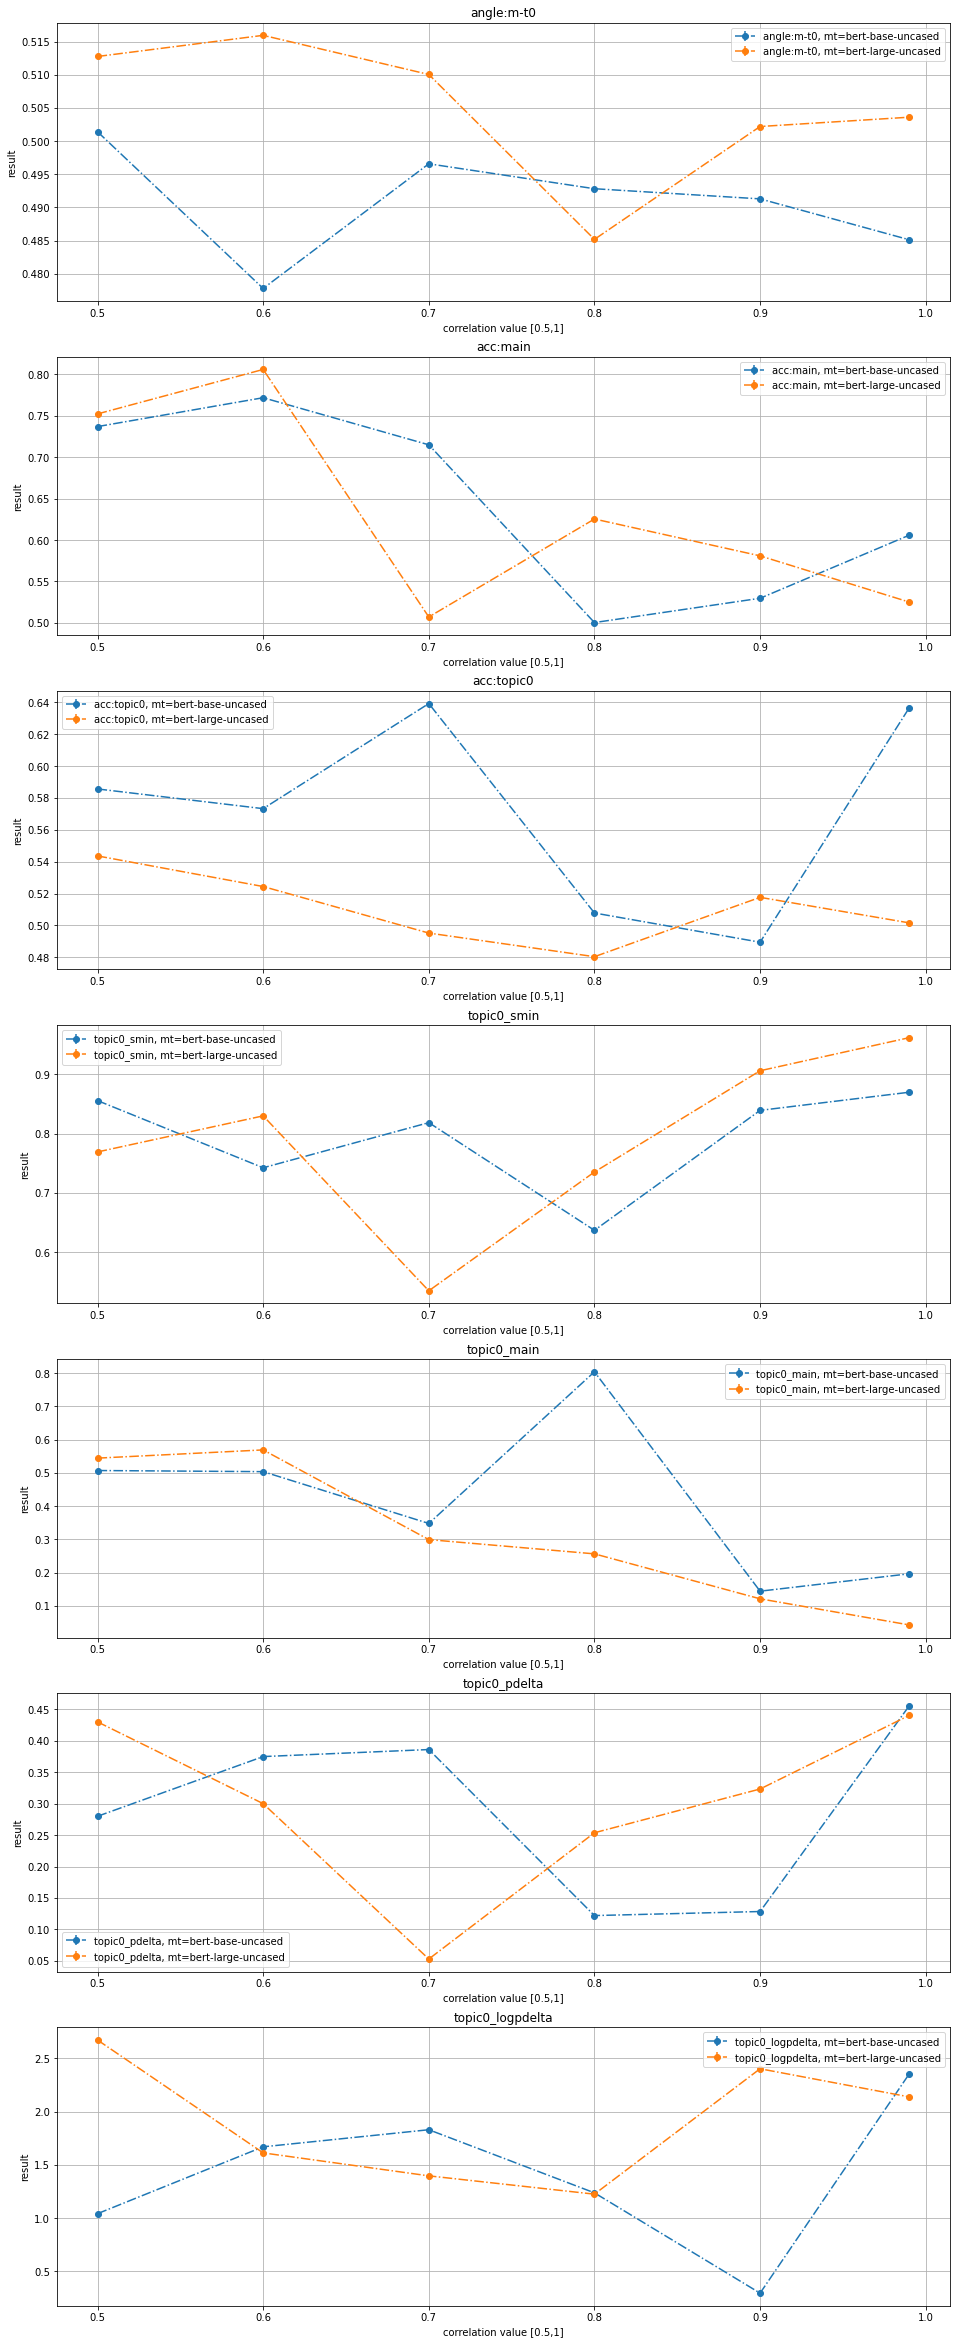

'\nAs the correlation is increasing the number of samples of minoroty group is also decreasing.\nSo, is the average minority group accuracy estimate good enough?\n'

In [6]:
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic0_logpdelta"
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
mainmode="causal"
n=0.0
h=0
mainepoch=3
s=10000
remmode="null_space"
advepoch=7
topicepoch=1

for model_type in ["bert-base-uncased","bert-large-uncased"]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                      pval_list=pval_list,
                                      enum=mainepoch+advepoch,
                                      fname_pattern="nlp_logs/pt.rel.model_type({}).remmode({}).advepoch({}).topicepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                              model_type,
                                                                              remmode,
                                                                              advepoch,
                                                                              topicepoch,
                                                                              lt,
                                                                              l2,
                                                                              hretrain,
                                                                              mainmode,
                                                                              n,
                                                                              h,
                                                                              s,
                                                                              mainepoch,
                                                                              "{}",
                                                                              "{}",
                                      )
    )
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", mt={}".format(model_type))

plt.show()


'''
As the correlation is increasing the number of samples of minoroty group is also decreasing.
So, is the average minority group accuracy estimate good enough?
'''

# Variation with noise

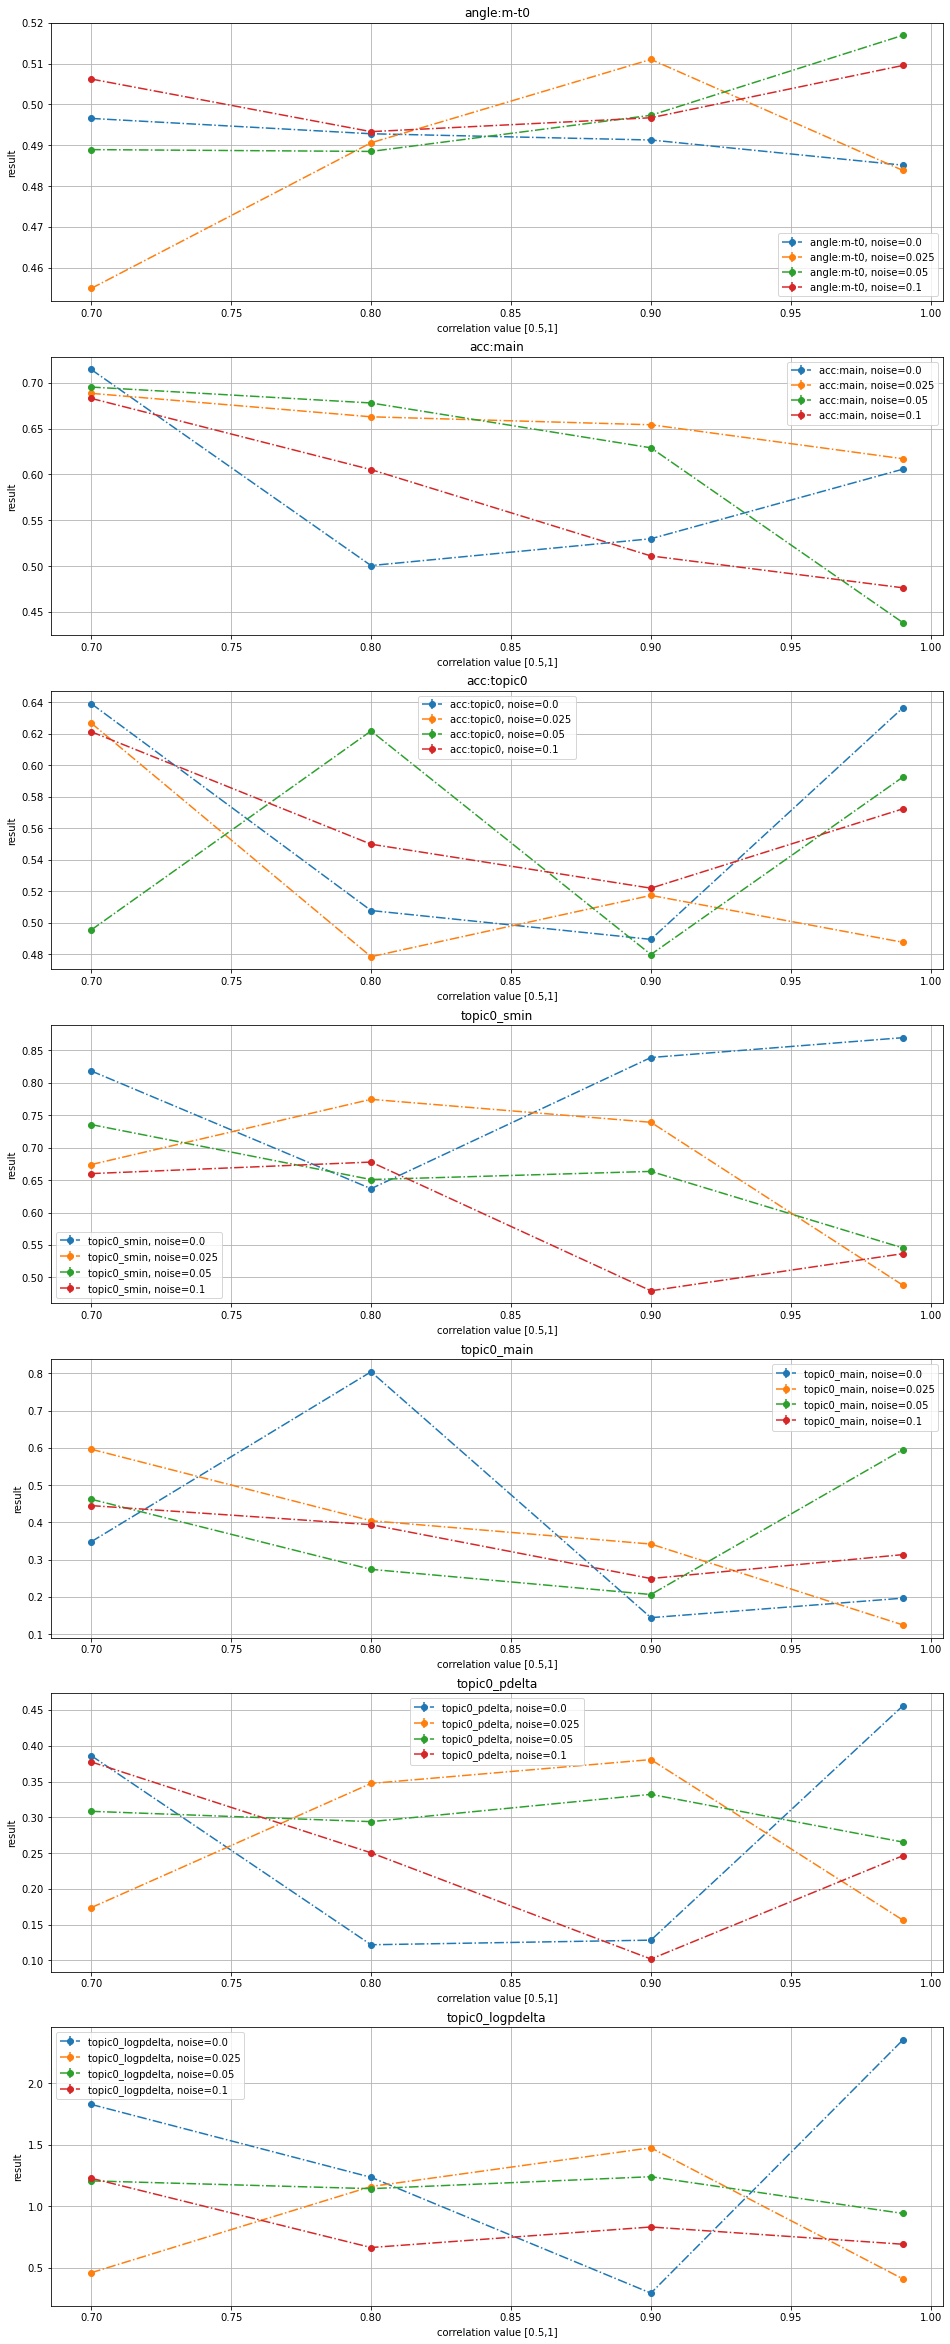

'\nAs the correlation is increasing the number of samples of minoroty group is also decreasing.\nSo, is the average minority group accuracy estimate good enough?\n'

In [12]:
run_list=[0,]
pval_list=[0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic0_logpdelta"
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
mainmode="causal"
n=0.0
h=0
mainepoch=3
s=10000
remmode="null_space"
advepoch=7
topicepoch=1

for n in [0.0,0.025,0.05,0.1]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                      pval_list=pval_list,
                                      enum=mainepoch+advepoch,
                                      fname_pattern="nlp_logs/pt.rel.model_type({}).remmode({}).advepoch({}).topicepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                              model_type,
                                                                              remmode,
                                                                              advepoch,
                                                                              topicepoch,
                                                                              lt,
                                                                              l2,
                                                                              hretrain,
                                                                              mainmode,
                                                                              n,
                                                                              h,
                                                                              s,
                                                                              mainepoch,
                                                                              "{}",
                                                                              "{}",
                                      )
    )
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", noise={}".format(n))

plt.show()


'''
As the correlation is increasing the number of samples of minoroty group is also decreasing.
So, is the average minority group accuracy estimate good enough?
'''

# Variation with epochs

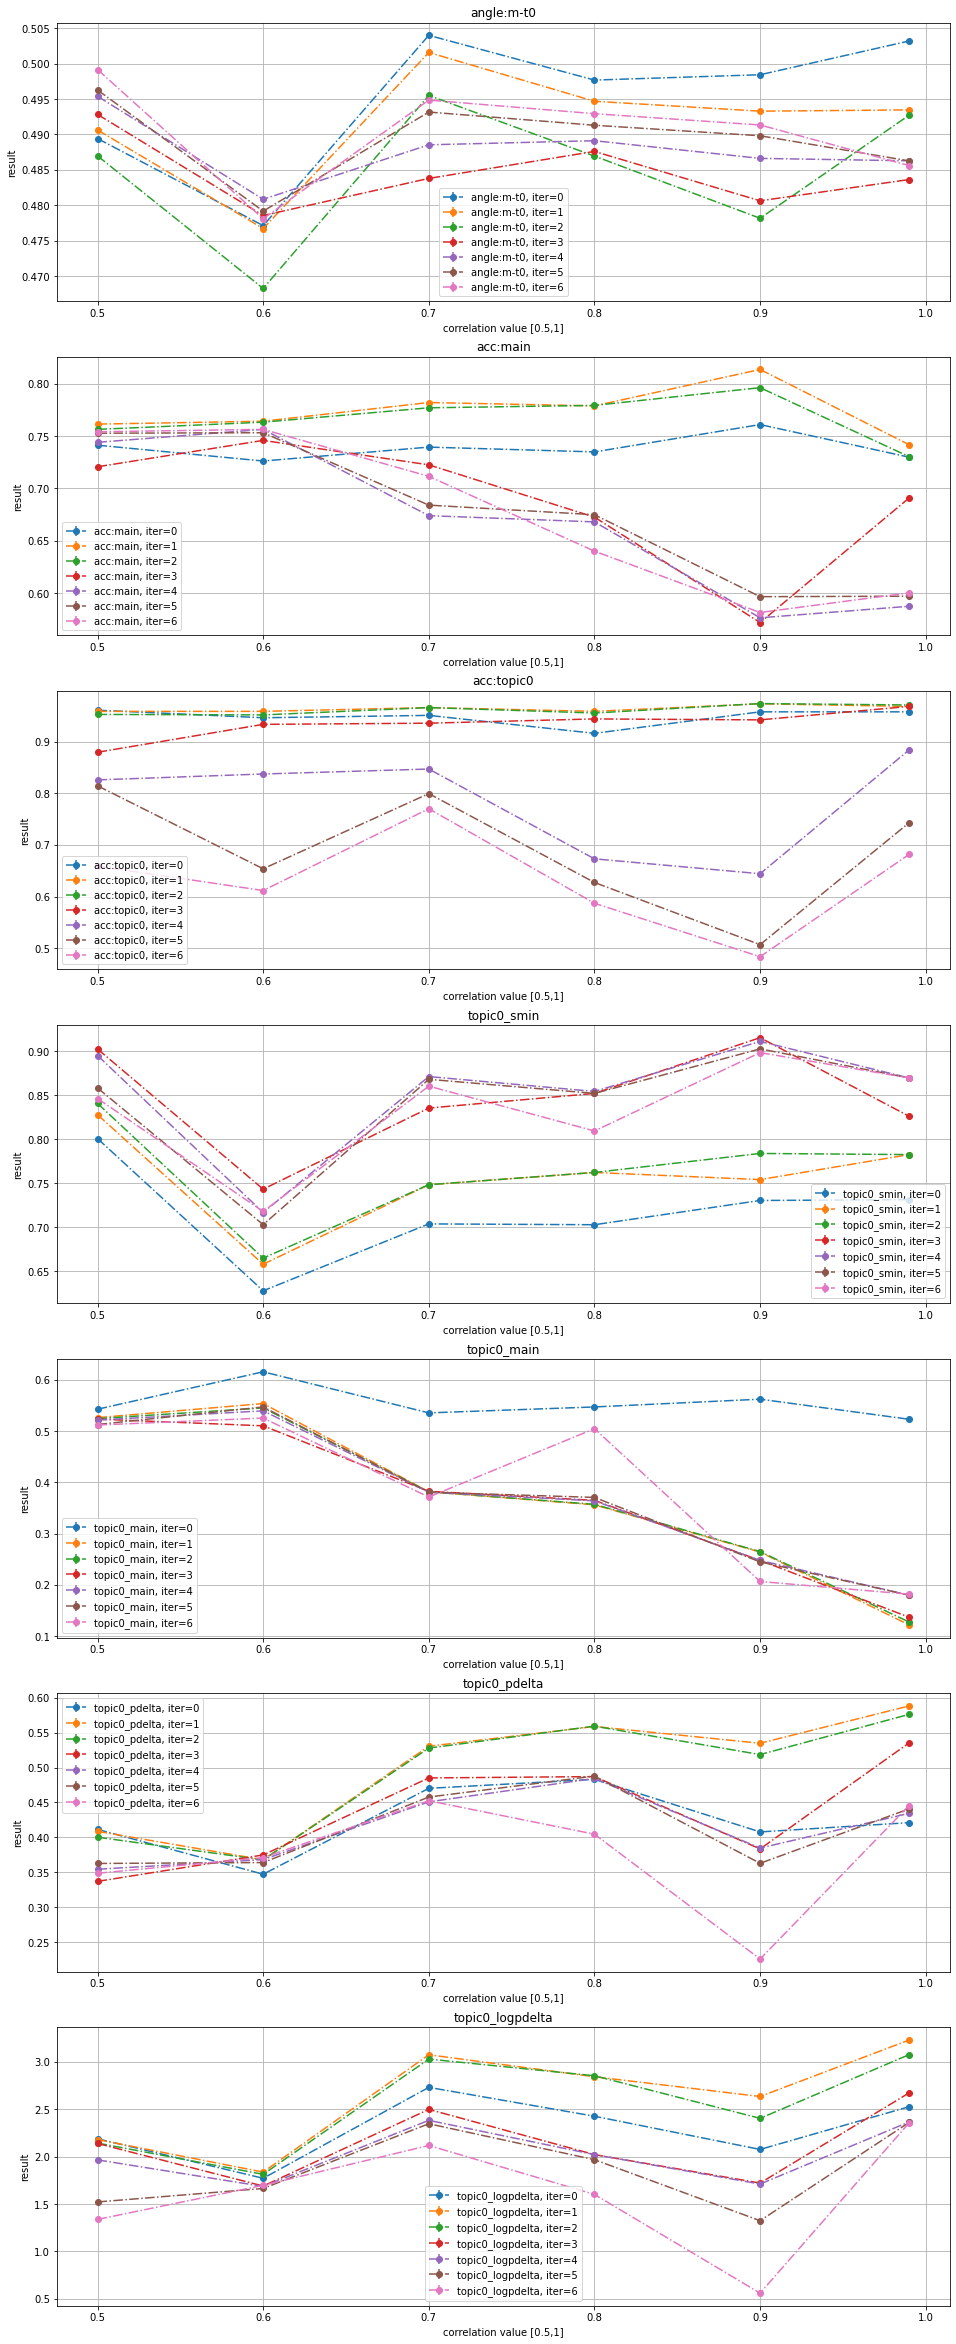

'\nAs the correlation is increasing the number of samples of minoroty group is also decreasing.\nSo, is the average minority group accuracy estimate good enough?\n'

In [13]:
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic0_logpdelta"
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
mainmode="causal"
n=0.0
h=0
mainepoch=3
s=10000
remmode="null_space"
advepoch=7
topicepoch=1

for rem_epoch_num in range(advepoch):
    all_result_dict = get_all_result_dict(run_list=run_list,
                                      pval_list=pval_list,
                                      enum=mainepoch+rem_epoch_num,
                                      fname_pattern="nlp_logs/pt.rel.model_type({}).remmode({}).advepoch({}).topicepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                              model_type,
                                                                              remmode,
                                                                              advepoch,
                                                                              topicepoch,
                                                                              lt,
                                                                              l2,
                                                                              hretrain,
                                                                              mainmode,
                                                                              n,
                                                                              h,
                                                                              s,
                                                                              mainepoch,
                                                                              "{}",
                                                                              "{}",
                                      )
    )
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", iter={}".format(rem_epoch_num))

plt.show()


'''
As the correlation is increasing the number of samples of minoroty group is also decreasing.
So, is the average minority group accuracy estimate good enough?
'''